In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time

"Machine learning tools"
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
import pickle

#from src.classification.datasets import Dataset
from src.classification.utils.plots import plot_specgram, show_confusion_matrix, plot_decision_boundaries
from src.classification.utils.utils import accuracy
#from src.classification.utils.audio_student import AudioUtil, Feature_vector_DS

In [14]:
np.random.seed(0)

In [15]:
fm_dir = "data/feature_matrices/" # where to save the features matrices
model_dir = "data/models/" # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

<font size=5 color=#009999> 1. Creation of the feature vectors matrix and dataset splitting </font> <br>


In [24]:
def create_FV_matrix(nb_FV=700): # number of FV, being the same for each class 
    start = time.time()
    classnames = ["birds", "chainsaw","fire","handsaw","helicopter"]
    labels = np.repeat(classnames, nb_FV)
    
    FV_matrix = np.zeros((nb_FV*len(classnames), 400))
    
    for i in range(nb_FV):
        fvi = np.load("src/classification/datasets/FV_birds/FV_bird"+str(i+1)+".npy")
        FV_matrix[i] = fvi
    print("birds loaded")
    
    for i in range(nb_FV):
        fvi = np.load("src/classification/datasets/FV_chainsaws/FV_chainsaw"+str(i+1)+".npy")
        FV_matrix[nb_FV + i] = fvi
    print("chainsaw loaded")
    
    for i in range(nb_FV):
        fvi = np.load("src/classification/datasets/FV_fires/FV_fire"+str(i+1)+".npy")
        FV_matrix[2*nb_FV + i] = fvi
    print("fire loaded")

    for i in range(nb_FV):
        fvi = np.load("src/classification/datasets/FV_handsaws/FV_handsaw"+str(i+1)+".npy")
        FV_matrix[3*nb_FV + i] = fvi
    print("handsaw loaded")

    for i in range(nb_FV):
        fvi = np.load("src/classification/datasets/FV_helicopters/FV_helicopter"+str(i+1)+".npy")
        FV_matrix[4*nb_FV + i] = fvi
    print("helicopter loaded")
 
    np.save(fm_dir+"Our_FV_matrix_2D___V3.npy", FV_matrix) # save the matrix to not load this cell again
    np.save(fm_dir+"Labels_matrix___V3.npy", labels)

    print("---------------------------------")
    print("nb_FV * nb_classes =", nb_FV * len(classnames))
    print(FV_matrix.shape)
    print(labels.shape)
    end = time.time()
    print("Temps d'exécution:",np.round(end-start,3),"[s]")

#create_FV_matrix()

birds loaded
chainsaw loaded
fire loaded
handsaw loaded
helicopter loaded
---------------------------------
nb_FV * nb_classes = 3500
(3500, 400)
(3500,)
Temps d'exécution: 11.326 [s]


In [16]:
classnames = ["birds", "chainsaw","fire","handsaw","helicopter"]
FV_matrix = np.load(fm_dir+"Our_FV_matrix_2D___V3.npy")
labels = np.load(fm_dir+"Labels_matrix___V3.npy")

In [26]:
# Shuffle then split the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(FV_matrix, labels, test_size=0.3, stratify=labels) # random_state=1

print('Shape of the training matrix : {}'.format(X_train.shape))
print('Number of training labels : {}'.format(len(y_train)))

Shape of the training matrix : (2450, 400)
Number of training labels : 2450


<font size=5 color=#009999> 2. Creation of models and training</font> <br>
Training with K-fold cross validation (to avoid overfitting) and normalisation

`TO STUDY :`
- Hyper parameters of the model
- Impact on the accuracy of number of folds chosen
- What happens with this normalisation countermeasure when there is no sound around the microphone? Is this desirable? How could we deal with it?

In [45]:
model_svm = svm.SVC(kernel="linear",gamma="scale",C=0.5, probability=True)

model_rft = RandomForestClassifier(n_estimators=100, criterion="log_loss",min_samples_split=5,min_samples_leaf=1,max_features="log2")

Split 1 / 7
Split 2 / 7
Split 3 / 7
Split 4 / 7
Split 5 / 7
Split 6 / 7
Split 7 / 7
-----------------------------------------------
Mean accuracy of SVM with 5-Fold CV: 52.3%
Std deviation in accuracy of SVM with 5-Fold CV: 2.0%
Accuracy of SVM on test set : 52.3%


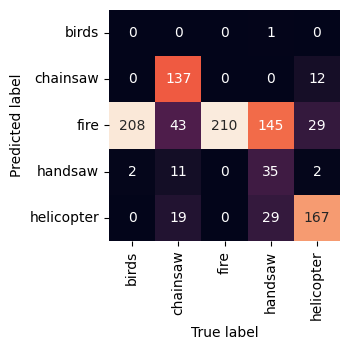


Mean accuracy of RFT with 5-Fold CV: 73.0%
Std deviation in accuracy of RFT with 5-Fold CV: 2.8%
Accuracy of RFT on test set : 73.0%


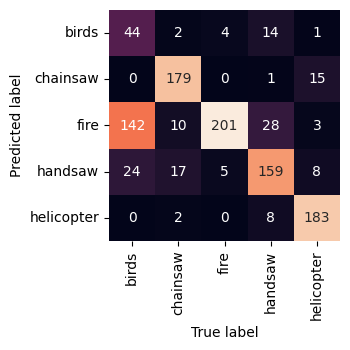

Temps d'exécution: 17.948 [s]


In [47]:
def training(n_splits=5, normalize=True):

    start = time.time()
    kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
    accuracyCV_svm = np.zeros((n_splits,))
    accuracyCV_rft = np.zeros((n_splits,))
    
    for k, idx in enumerate(kf.split(X_train,y_train)):
        print("Split",k+1,"/",n_splits)
        (idx_learn, idx_val) = idx

        if normalize == True :
            X_learn_normalised = X_train[idx_learn]/ np.linalg.norm(X_train[idx_learn], axis=1, keepdims=True)
            X_val_normalised = X_train[idx_val]/ np.linalg.norm(X_train[idx_val], axis=1, keepdims=True)
        else :
            X_learn_normalised = X_train[idx_learn]
            X_val_normalised = X_train[idx_val]
            
        model_svm.fit(X_learn_normalised, y_train[idx_learn])
        prediction_svm = model_svm.predict(X_val_normalised)
        accuracyCV_svm[k] = accuracy(prediction_svm, y_train[idx_val])

        model_rft.fit(X_learn_normalised, y_train[idx_learn])
        prediction_rft = model_rft.predict(X_val_normalised)
        accuracyCV_rft[k] = accuracy(prediction_rft, y_train[idx_val])

    
    if normalize == True :
        X_test_normalised = X_test / np.linalg.norm(X_test, axis=1, keepdims=True)
    else :
        X_test_normalised = X_test
        
    prediction_svm = model_svm.predict(X_test_normalised)
    prediction_rft = model_rft.predict(X_test_normalised)
    accuracy_svm = accuracy (prediction_svm, y_test)
    accuracy_rft = accuracy (prediction_rft, y_test)

    print("-----------------------------------------------")
    print('Mean accuracy of SVM with 5-Fold CV: {:.1f}%'.format(100*accuracy_svm.mean()))
    print('Std deviation in accuracy of SVM with 5-Fold CV: {:.1f}%'.format(100*accuracyCV_svm.std()))
    print('Accuracy of SVM on test set : {:.1f}%'.format(100*accuracy_svm))
    show_confusion_matrix (prediction_svm, y_test, classnames)
    print()
    print('Mean accuracy of RFT with 5-Fold CV: {:.1f}%'.format(100*accuracy_rft.mean()))
    print('Std deviation in accuracy of RFT with 5-Fold CV: {:.1f}%'.format(100*accuracyCV_rft.std()))
    print('Accuracy of RFT on test set : {:.1f}%'.format(100*accuracy_rft))
    show_confusion_matrix (prediction_rft, y_test, classnames)

    end = time.time()
    print("Temps d'exécution:",np.round(end-start,3),"[s]")

training(n_splits=7, normalize=True)

<font size=5 color=#009999> 3. Memory and probabilities</font> <br>

Label : birds
Prediction of RFT : birds
probabilities : [0.83 0.01 0.   0.16 0.  ]
Prediction of SVM : birds
probabilities : [0.89238313 0.02301436 0.00695173 0.05991098 0.01773978]


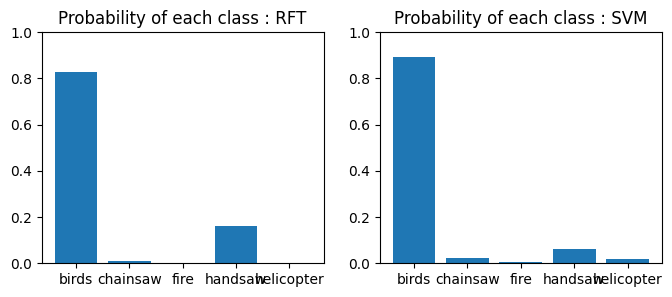

In [76]:
# Visualize a prediction

idx_FV = 3   # FV chosen in the matrix

FV = FV_matrix[idx_FV]
lab = labels[idx_FV]
pred_rft = model_rft.predict(FV.reshape((1,400)))
proba_rft = model_rft.predict_proba(FV.reshape((1,400)))
pred_svm = model_svm.predict(FV.reshape((1,400)))
proba_svm = model_svm.predict_proba(FV.reshape((1,400)))

print("Label :", lab)
print("Prediction of RFT :",pred_rft[0])
print("probabilities :", proba_rft[0])
print("Prediction of SVM :",pred_svm[0])
print("probabilities :", proba_svm[0])

fig,ax = plt.subplots(1,2, figsize=(8,3))
ax[0].bar(classnames, proba_rft[0])
ax[1].bar(classnames, proba_svm[0])
ax[0].set_title('Probability of each class : RFT')
ax[1].set_title('Probability of each class : SVM')
ax[0].set_ylim([0.0,1.0])
ax[1].set_ylim([0.0,1.0])
plt.show()

True labels : ['chainsaw', 'chainsaw', 'chainsaw', 'chainsaw', 'chainsaw']


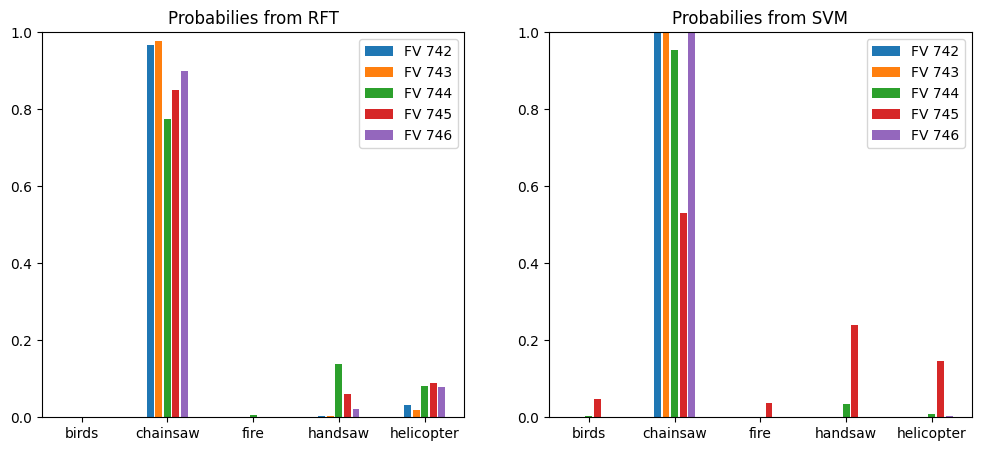

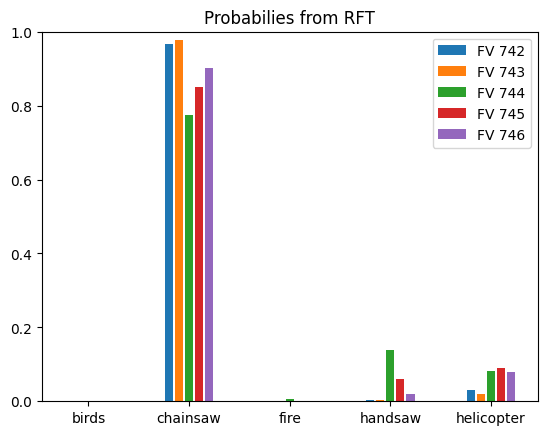

In [43]:
# Probabilities of consecutive FV

start_idx = 742
N = 5 # nbr of FV we're looking at

pred_rft = np.zeros((N, len(classnames)))
pred_svm = np.zeros((N, len(classnames)))
labs = []

for i in range(N):
    labs.append(labels[start_idx+i])
    pred_rft[i] = model_rft.predict_proba(FV_matrix[start_idx+i].reshape((1,400)))
    pred_svm[i] = model_svm.predict_proba(FV_matrix[start_idx+i].reshape((1,400)))



print("True labels :",labs)

fig,ax = plt.subplots(1,2,figsize=(12,5))
for i in range(N):
    ax[0].bar(np.arange(len(classnames))*2*N+i, pred_rft[i], label='FV {}'.format(start_idx+i))
    ax[1].bar(np.arange(len(classnames))*2*N+i, pred_svm[i], label='FV {}'.format(start_idx+i))
ax[0].legend()
ax[1].legend()
ax[0].set_xticks(np.arange(len(classnames))*2*N+2)
ax[0].set_xticklabels(classnames)
ax[1].set_xticks(np.arange(len(classnames))*2*N+2)
ax[1].set_xticklabels(classnames)
ax[0].set_title("Probabilies from RFT")
ax[1].set_title("Probabilies from SVM")
ax[0].set_ylim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.0])
plt.show()

plt.figure()
for i in range(N):
    plt.bar(np.arange(len(classnames))*2*N+i, pred_rft[i], label='FV {}'.format(start_idx+i))
plt.legend()
plt.gca().set_xticks(np.arange(len(classnames))*2*N+2)
plt.gca().set_xticklabels(classnames)
plt.title("Probabilies from RFT")
plt.ylim([0.0,1.0])
plt.show()

In [149]:
# Test mémoire : différentes méthodes

start_idx = 700 + 696
N = 10 # nbr of FV in memory

pred_rft = np.zeros((N, len(classnames)))
pred_svm = np.zeros((N, len(classnames)))

for i in range(N):
    pred_rft[i] = model_rft.predict_proba(FV_matrix[start_idx+i].reshape((1,400)))
    pred_svm[i] = model_svm.predict_proba(FV_matrix[start_idx+i].reshape((1,400)))


print(pred_rft)
print()
print("True label :        ",labels[start_idx+N])
print()

#####  1. Naïve implementation #####
# Select the class that has the highest probability among all the considered feature vectors.

idx = np.where(pred_rft == np.max(pred_rft))
print("Naïve prediction :  ", classnames[idx[1][0]])

#####  2. Majority voting #####
# Select the class that appears most often as the maximum probability of a feature vector.

counter_max = np.zeros(len(classnames))
for i in range(N):
    idx = np.where(pred_rft[i] == np.max(pred_rft[i]))
    counter_max[idx[0][0]] += 1
idx = np.where(counter_max == np.max(counter_max))
print("Majority voting :   ", classnames[idx[0][0]])

#####  3. Average the feature representation #####
# Compute the average of all feature vectors and classify from this average.

av_prob = np.sum(pred_rft, axis=0) / len(classnames)
idx = np.where(av_prob == np.max(av_prob))
print("Averaging FV :      ", classnames[idx[0][0]])

#####  4. Maximum loglikelihood #####
# Select the class that maximises the sum of log

logs = np.log(pred_rft)
loglikelihood = np.sum(logs,axis=0)
idx = np.where(loglikelihood == np.max(loglikelihood))
print("Maximum likelihood :", classnames[idx[0][0]])
print()

[[0.         0.78       0.         0.16       0.06      ]
 [0.38968678 0.01531786 0.5219667  0.06377646 0.0092522 ]
 [0.         0.86       0.         0.04       0.1       ]
 [0.02       0.58       0.01       0.24       0.15      ]
 [0.38968678 0.01531786 0.5219667  0.06377646 0.0092522 ]
 [0.38968678 0.01531786 0.5219667  0.06377646 0.0092522 ]
 [0.38968678 0.01531786 0.5219667  0.06377646 0.0092522 ]
 [0.38968678 0.01531786 0.5219667  0.06377646 0.0092522 ]
 [0.38968678 0.01531786 0.5219667  0.06377646 0.0092522 ]
 [0.38968678 0.01531786 0.5219667  0.06377646 0.0092522 ]]

True label :         fire

Naïve prediction :   chainsaw
Majority voting :    fire
Averaging FV :       fire
Maximum likelihood : handsaw



In [150]:
# Mesures de performances des différentes méthodes
import warnings
warnings.filterwarnings("ignore")

def Naive(pred) :
    idx = np.where(pred == np.max(pred))
    return idx[1][0]

def Majority_voting(pred) :
    counter_max = np.zeros(len(classnames))
    for i in range(N):
        idx = np.where(pred[i] == np.max(pred[i]))
        counter_max[idx[0][0]] += 1
    idx = np.where(counter_max == np.max(counter_max))
    return idx[0][0]
    
def Averaging_FV(pred) :
    av_prob = np.sum(pred, axis=0) / len(classnames)
    idx = np.where(av_prob == np.max(av_prob))
    return idx[0][0]

def ML(pred) :
    logs = np.log(pred)
    loglikelihood = np.sum(logs,axis=0)
    idx = np.where(loglikelihood == np.max(loglikelihood))
    return idx[0][0]


N = 10

pred_Nv = np.zeros(len(classnames))
pred_Mv = np.zeros(len(classnames))
pred_Av = np.zeros(len(classnames))
pred_Ml = np.zeros(len(classnames))

for idx in range(700-N) :  # performance sur les birds
    
    pred_rft = np.zeros((N, len(classnames)))
    for i in range(N):
        pred_rft[i] = model_rft.predict_proba(FV_matrix[idx+i].reshape((1,400)))
        
    pred_Nv[Naive(pred_rft)] += 1
    pred_Mv[Majority_voting(pred_rft)] += 1
    pred_Av[Averaging_FV(pred_rft)] += 1
    pred_Ml[ML(pred_rft)] += 1

print("Test on birds :")
print(pred_Nv, "--->",np.round(pred_Nv[0]*100/np.sum(pred_Nv),2),"% correct")
print(pred_Mv, "--->",np.round(pred_Mv[0]*100/np.sum(pred_Mv),2),"% correct")
print(pred_Av, "--->",np.round(pred_Av[0]*100/np.sum(pred_Av),2),"% correct")
print(pred_Ml, "--->",np.round(pred_Ml[0]*100/np.sum(pred_Ml),2),"% correct")
print()



pred_Nv = np.zeros(len(classnames))
pred_Mv = np.zeros(len(classnames))
pred_Av = np.zeros(len(classnames))
pred_Ml = np.zeros(len(classnames))

for idx in range(700,2*700-N) :  # performance sur les chainsaws
    
    pred_rft = np.zeros((N, len(classnames)))
    for i in range(N):
        pred_rft[i] = model_rft.predict_proba(FV_matrix[idx+i].reshape((1,400)))
        
    pred_Nv[Naive(pred_rft)] += 1
    pred_Mv[Majority_voting(pred_rft)] += 1
    pred_Av[Averaging_FV(pred_rft)] += 1
    pred_Ml[ML(pred_rft)] += 1

print("Test on chainsaws :")
print(pred_Nv, "--->",np.round(pred_Nv[1]*100/np.sum(pred_Nv),2),"% correct")
print(pred_Mv, "--->",np.round(pred_Mv[1]*100/np.sum(pred_Mv),2),"% correct")
print(pred_Av, "--->",np.round(pred_Av[1]*100/np.sum(pred_Av),2),"% correct")
print(pred_Ml, "--->",np.round(pred_Ml[1]*100/np.sum(pred_Ml),2),"% correct")
print()



pred_Nv = np.zeros(len(classnames))
pred_Mv = np.zeros(len(classnames))
pred_Av = np.zeros(len(classnames))
pred_Ml = np.zeros(len(classnames))

for idx in range(2*700,3*700-N) :  # performance sur les fires
    
    pred_rft = np.zeros((N, len(classnames)))
    for i in range(N):
        pred_rft[i] = model_rft.predict_proba(FV_matrix[idx+i].reshape((1,400)))
        
    pred_Nv[Naive(pred_rft)] += 1
    pred_Mv[Majority_voting(pred_rft)] += 1
    pred_Av[Averaging_FV(pred_rft)] += 1
    pred_Ml[ML(pred_rft)] += 1

print("Test on fires :")
print(pred_Nv, "--->",np.round(pred_Nv[2]*100/np.sum(pred_Nv),2),"% correct")
print(pred_Mv, "--->",np.round(pred_Mv[2]*100/np.sum(pred_Mv),2),"% correct")
print(pred_Av, "--->",np.round(pred_Av[2]*100/np.sum(pred_Av),2),"% correct")
print(pred_Ml, "--->",np.round(pred_Ml[2]*100/np.sum(pred_Ml),2),"% correct")
print()




pred_Nv = np.zeros(len(classnames))
pred_Mv = np.zeros(len(classnames))
pred_Av = np.zeros(len(classnames))
pred_Ml = np.zeros(len(classnames))

for idx in range(3*700,4*700-N) :  # performance sur les handsaws
    
    pred_rft = np.zeros((N, len(classnames)))
    for i in range(N):
        pred_rft[i] = model_rft.predict_proba(FV_matrix[idx+i].reshape((1,400)))
        
    pred_Nv[Naive(pred_rft)] += 1
    pred_Mv[Majority_voting(pred_rft)] += 1
    pred_Av[Averaging_FV(pred_rft)] += 1
    pred_Ml[ML(pred_rft)] += 1

print("Test on handsaws :")
print(pred_Nv, "--->",np.round(pred_Nv[3]*100/np.sum(pred_Nv),2),"% correct")
print(pred_Mv, "--->",np.round(pred_Mv[3]*100/np.sum(pred_Mv),2),"% correct")
print(pred_Av, "--->",np.round(pred_Av[3]*100/np.sum(pred_Av),2),"% correct")
print(pred_Ml, "--->",np.round(pred_Ml[3]*100/np.sum(pred_Ml),2),"% correct")
print()




pred_Nv = np.zeros(len(classnames))
pred_Mv = np.zeros(len(classnames))
pred_Av = np.zeros(len(classnames))
pred_Ml = np.zeros(len(classnames))

for idx in range(4*700,5*700-N) :  # performance sur les helicopters
    
    pred_rft = np.zeros((N, len(classnames)))
    for i in range(N):
        pred_rft[i] = model_rft.predict_proba(FV_matrix[idx+i].reshape((1,400)))
        
    pred_Nv[Naive(pred_rft)] += 1
    pred_Mv[Majority_voting(pred_rft)] += 1
    pred_Av[Averaging_FV(pred_rft)] += 1
    pred_Ml[ML(pred_rft)] += 1

print("Test on helicopters :")
print(pred_Nv, "--->",np.round(pred_Nv[4]*100/np.sum(pred_Nv),2),"% correct")
print(pred_Mv, "--->",np.round(pred_Mv[4]*100/np.sum(pred_Mv),2),"% correct")
print(pred_Av, "--->",np.round(pred_Av[4]*100/np.sum(pred_Av),2),"% correct")
print(pred_Ml, "--->",np.round(pred_Ml[4]*100/np.sum(pred_Ml),2),"% correct")
print()

Test on birds :
[626.   0.  61.   3.   0.] ---> 90.72 % correct
[ 66.   0. 620.   4.   0.] ---> 9.57 % correct
[493.   0. 196.   1.   0.] ---> 71.45 % correct
[547.   0. 133.  10.   0.] ---> 79.28 % correct

Test on chainsaws :
[  0. 680.   0.  10.   0.] ---> 98.55 % correct
[  0. 690.   0.   0.   0.] ---> 100.0 % correct
[  0. 690.   0.   0.   0.] ---> 100.0 % correct
[  0. 690.   0.   0.   0.] ---> 100.0 % correct

Test on fires :
[ 52.   0. 618.  20.   0.] ---> 89.57 % correct
[  0.   0. 690.   0.   0.] ---> 100.0 % correct
[  7.   0. 683.   0.   0.] ---> 98.99 % correct
[ 16.   0. 674.   0.   0.] ---> 97.68 % correct

Test on handsaws :
[  0.   0.   0. 690.   0.] ---> 100.0 % correct
[  0.   0.   0. 690.   0.] ---> 100.0 % correct
[  0.   0.   0. 690.   0.] ---> 100.0 % correct
[  0.   0.   0. 690.   0.] ---> 100.0 % correct

Test on helicopters :
[  0.   0.   0.   0. 690.] ---> 100.0 % correct
[  0.   0.   5.   0. 685.] ---> 99.28 % correct
[  0.   0.   3.   0. 687.] ---> 99.57 % 

In [164]:
# Comment gérer la mémoire : arrays vs listes


#----- Arrays -----
memory_size = 5
memory = np.zeros((memory_size,len(classnames)))
idx_empty = 0

def add_in_memory(m, idx, vp) :
    if idx < memory_size :
        m[idx] = vp
        return idx+1
    else:
        for i in range (memory_size-1):
            m[i] = m[i+1]
        m[-1] = vp
        return idx

test_vp = np.array([[0, 0.2, 0.45, 0.16, 0.01],
                    [0.3, 0.6, 0.0, 0.0, 0.1 ],
                    [0.7, 0.01, 0.02, 0, 0.03],
                    [0.5, 0.1, 0.1, 0, 0.02  ],
                    [0.2, 0.1, 0.4, 0.1, 0.0 ],
                    [0.01, 0.023, 0.54, 0, 0 ],
                    [0.04, 0.05, 0.73, 0.2, 0],
                    [0.09, 0.1, 0.4, 0.2, 0.1],
                    [0.4, 0.1, 0.2, 0.1, 0.1 ] ])

print("----TEST WITH ARRAYS----")
for i in range(len(test_vp)) :
    start = time.time()
    idx_empty = add_in_memory(memory, idx_empty, test_vp[i])
    stop = time.time()

    print("Iteration",i,": execution time :",np.round((stop-start)*10**3, 3),"[ms]")
    print(memory)
    print()


#----- Lists -----

memory = []
def update_memory(vp):
    if len(memory) < memory_size :
        memory.append(vp)
        return
    else :
        del memory[0]
        memory.append(vp)
        return

print("----TEST WITH LISTS----")
for i in range(len(test_vp)) :
    start = time.time()
    update_memory(test_vp[i])
    stop = time.time()

    print("Iteration",i,": execution time :",np.round((stop-start)*10**3, 3),"[ms]")
    print(np.array(memory))
    print()

print(memory)

----TEST WITH ARRAYS----
Iteration 0 : execution time : 0.035 [ms]
[[0.   0.2  0.45 0.16 0.01]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]

Iteration 1 : execution time : 0.027 [ms]
[[0.   0.2  0.45 0.16 0.01]
 [0.3  0.6  0.   0.   0.1 ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]

Iteration 2 : execution time : 0.027 [ms]
[[0.   0.2  0.45 0.16 0.01]
 [0.3  0.6  0.   0.   0.1 ]
 [0.7  0.01 0.02 0.   0.03]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]

Iteration 3 : execution time : 0.025 [ms]
[[0.   0.2  0.45 0.16 0.01]
 [0.3  0.6  0.   0.   0.1 ]
 [0.7  0.01 0.02 0.   0.03]
 [0.5  0.1  0.1  0.   0.02]
 [0.   0.   0.   0.   0.  ]]

Iteration 4 : execution time : 0.023 [ms]
[[0.   0.2  0.45 0.16 0.01]
 [0.3  0.6  0.   0.   0.1 ]
 [0.7  0.01 0.02 0.   0.03]
 [0.5  0.1  0.1  0.   0.02]
 [0.2  0.1  0.4  0.1  0.  ]]

Iteration 5 : execution time : 0.166 [ms]
[[0.3   0.6  

In [172]:
min = np.inf
max = -np.inf
for FV in FV_matrix:
    norm = np.linalg.norm(FV)
    if norm > max :
        max = norm
    if norm < min :
        min = norm

print()
print()
print("max :",max)
print("min :",min)
    



max : 100857.17743423123
min : 45794.672179195695


<font size=5 color=#009999> 4.1 Study of hyperparameters : SVM</font> <br>

n_splits =  2
n_splits =  3
n_splits =  4
n_splits =  5
n_splits =  6
n_splits =  7
n_splits =  8
n_splits =  9
n_splits =  10
n_splits =  11
n_splits =  12
n_splits =  13
n_splits =  14
n_splits =  15
n_splits =  16
n_splits =  17
n_splits =  18
n_splits =  19
n_splits =  20
n_splits =  21
n_splits =  22
n_splits =  23
n_splits =  24
n_splits =  25
n_splits =  26
n_splits =  27
n_splits =  28
n_splits =  29
n_splits =  30
n_splits =  31
n_splits =  32
n_splits =  33
n_splits =  34
n_splits =  35
n_splits =  36
n_splits =  37
n_splits =  38
n_splits =  39
n_splits =  40
n_splits =  41
n_splits =  42
n_splits =  43
n_splits =  44
n_splits =  45
n_splits =  46
n_splits =  47
n_splits =  48
n_splits =  49


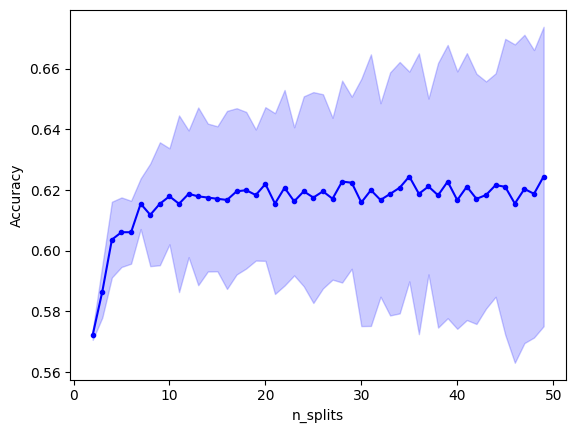

means svm :
[0.5722449  0.58652581 0.60367887 0.60612245 0.60611826 0.6155102
 0.61184694 0.61549684 0.61795918 0.61549748 0.61877292 0.61794352
 0.61755102 0.61714051 0.6167611  0.61959657 0.61996982 0.61837324
 0.62201786 0.61556356 0.620788   0.61629726 0.61960229 0.61755102
 0.61959686 0.61716637 0.6228215  0.62243794 0.61593396 0.61999285
 0.61674962 0.6187442  0.62080312 0.6244898  0.61879559 0.6211999
 0.61830086 0.62280909 0.61671074 0.62115888 0.61712031 0.61839191
 0.6216647  0.62108492 0.61556224 0.62038724 0.61878614 0.6244898 ]
stds svm :
[0.00163265 0.00855992 0.01248812 0.01147222 0.01037617 0.00834492
 0.01691741 0.02026783 0.01582916 0.02912701 0.02090149 0.0293
 0.02438413 0.02390951 0.02935159 0.02741369 0.02581308 0.02161067
 0.02533279 0.02980752 0.032244   0.02442528 0.03131815 0.03476823
 0.03201151 0.02668651 0.03328781 0.02837748 0.04077018 0.04477341
 0.03190023 0.04007078 0.04145312 0.03458567 0.04629732 0.02898411
 0.04363714 0.04505561 0.04243818 0.0440075 

In [30]:
############# SVM ###############
#----- nb splits in K-Fold -----#

n_splits = np.arange(2,50,1)
accuracies_svm = [] #np.zeros((len(n_splits), len(n_splits)))

for i,nsplt in enumerate(n_splits):
    print("n_splits = ",nsplt)
    model_svm = svm.SVC()
    kf = StratifiedKFold(n_splits=nsplt,shuffle=True)
    acc_i = []
    
    for k, idx in enumerate(kf.split(X_train,y_train)):
            (idx_learn, idx_val) = idx
        
            model_svm.fit(X_train[idx_learn], y_train[idx_learn])
            prediction_svm = model_svm.predict(X_train[idx_val])
            acc_i.append(accuracy(prediction_svm, y_train[idx_val]))
    accuracies_svm.append(acc_i)
        
means_svm = np.zeros(len(n_splits))
stds_svm = np.zeros(len(n_splits))
for i in range(len(n_splits)):
    means_svm[i] = np.array(accuracies_svm[i]).mean()
    stds_svm[i] = np.array(accuracies_svm[i]).std()


plt.figure()
plt.plot(n_splits,means_svm,'.-b')
plt.fill_between(n_splits,means_svm-stds_svm,means_svm+stds_svm,alpha=0.2,color='b')
plt.xlabel('n_splits')
plt.ylabel('Accuracy')
#plt.ylim([0.8,1])
#plt.legend()
plt.show()
print("means svm :")
print(means_svm)
print("stds svm :")
print(stds_svm)

/tmp/ipykernel_940/2342362806.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["","linear","", "poly","", "rbf", "","sigmoid"])


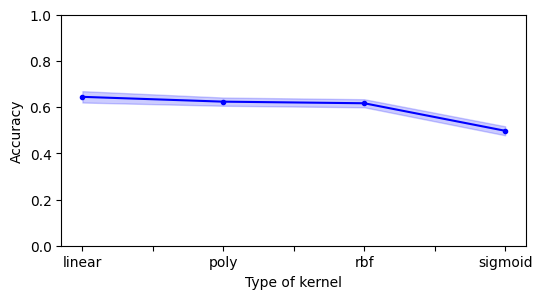

[0.6444898  0.62367347 0.61673469 0.49755102]


In [39]:
########## SVM #############
#----- Type of kernel -----#

n_splits = 7
kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
kernels = ["linear", "poly", "rbf", "sigmoid"]
accuracies_svm = np.zeros((len(kernels), n_splits))

for i,K in enumerate(kernels):
    model_svm = svm.SVC(kernel=K) 
    
    for k, idx in enumerate(kf.split(X_train,y_train)):
            (idx_learn, idx_val) = idx
            model_svm.fit(X_train[idx_learn], y_train[idx_learn])
            prediction_svm = model_svm.predict(X_train[idx_val])
            accuracies_svm[i,k] = accuracy(prediction_svm, y_train[idx_val])
        
means_svm = accuracies_svm.mean(axis=1)
stds_svm = accuracies_svm.std(axis=1)


fig, ax = plt.subplots(figsize=(6,3))
ax.plot(np.arange(0,len(kernels),1), means_svm, '.-b')
ax.fill_between(np.arange(0,len(kernels),1),means_svm-stds_svm,means_svm+stds_svm,alpha=0.2,color='b')
ax.set_xticklabels(["","linear","", "poly","", "rbf", "","sigmoid"])
plt.ylim(0,1)
ax.set_xlabel('Type of kernel')
ax.set_ylabel('Accuracy')
plt.show()
print(means_svm)

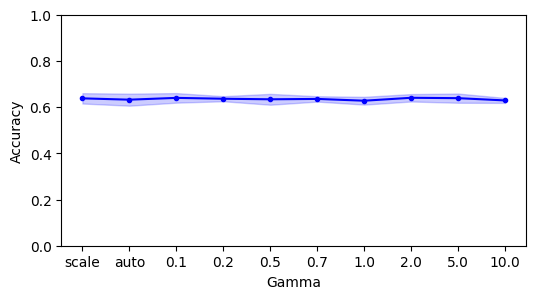

[0.63795918 0.6322449  0.64       0.63632653 0.63387755 0.6355102
 0.6277551  0.64040816 0.63877551 0.62897959]


In [7]:
########## SVM #############
#------ Gamma (RBF) -------#

n_splits = 7
kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
gamma = ["scale","auto", 0.1, 0.2, 0.5, 0.7, 1.0, 2.0, 5.0, 10.0]
accuracies_svm = np.zeros((len(gamma), n_splits))

for i, g in enumerate(gamma):
    model_svm = svm.SVC(kernel="linear", gamma=g) 
    
    for k, idx in enumerate(kf.split(X_train,y_train)):
            (idx_learn, idx_val) = idx
            model_svm.fit(X_train[idx_learn], y_train[idx_learn])
            prediction_svm = model_svm.predict(X_train[idx_val])
            accuracies_svm[i,k] = accuracy(prediction_svm, y_train[idx_val])
        
means_svm = accuracies_svm.mean(axis=1)
stds_svm = accuracies_svm.std(axis=1)


plt.figure(figsize=(6,3))
plt.plot(np.arange(0,len(gamma),1), means_svm, '.-b')
plt.fill_between(np.arange(0,len(gamma),1),means_svm-stds_svm,means_svm+stds_svm,alpha=0.2,color='b')
plt.xticks(np.arange(0,len(gamma),1),gamma)
plt.ylim(0,1)
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.show()
print(means_svm)

0.5
1
2
3
4
5


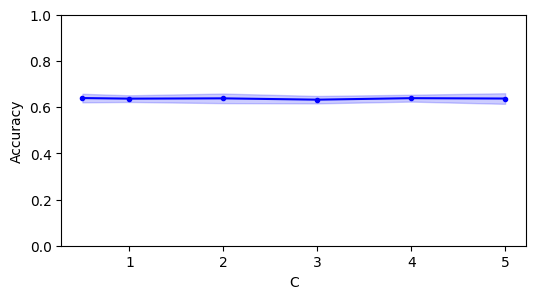

[0.63918367 0.63673469 0.63795918 0.6322449  0.63877551 0.63714286]


In [9]:
########## SVM #############
#-------- C (RBF) ---------#

n_splits = 7
kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
C = [0.5,1,2,3,4,5]
accuracies_svm = np.zeros((len(C), n_splits))

for i, c in enumerate(C):
    print(c)
    model_svm = svm.SVC(kernel="linear", C=c) 
    
    for k, idx in enumerate(kf.split(X_train,y_train)):
            (idx_learn, idx_val) = idx
            model_svm.fit(X_train[idx_learn], y_train[idx_learn])
            prediction_svm = model_svm.predict(X_train[idx_val])
            accuracies_svm[i,k] = accuracy(prediction_svm, y_train[idx_val])
        
means_svm = accuracies_svm.mean(axis=1)
stds_svm = accuracies_svm.std(axis=1)


plt.figure(figsize=(6,3))
plt.plot(C, means_svm, '.-b')
plt.fill_between(C,means_svm-stds_svm,means_svm+stds_svm,alpha=0.2,color='b')
#plt.xticks(np.arange(0,len(gamma),1),["scale","auto", 0.1, 0.2, 0.5, 0.7, 1.0, 2.0, 5.0, 10.0, 50.0])
plt.ylim(0,1)
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()
print(means_svm)

In [ ]:
############ SVM ###############
#------ LinearSVC tuning ------#

n_splits = 7
kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
loss = ["hinge", "squared_hinge"]
accuracies_lin = np.zeros((len(loss), n_splits))

for i, l in enumerate(loss):
    model_lin = svm.LinearSVC(dual="auto", max_iter=1000000, loss=l) 
    
    for k, idx in enumerate(kf.split(X_train,y_train)):
            (idx_learn, idx_val) = idx
            model_lin.fit(X_train[idx_learn], y_train[idx_learn])
            prediction_lin = model_lin.predict(X_train[idx_val])
            accuracies_lin[i,k] = accuracy(prediction_lin, y_train[idx_val])
        
means_lin = accuracies_lin.mean(axis=1)
stds_lin = accuracies_lin.std(axis=1)

plt.figure(figsize=(6,3))
plt.plot(np.arange(0,len(loss),1), means_lin, '.-b')
plt.fill_between(np.arange(0,len(loss),1),means_lin-stds_lin,means_lin+stds_lin,alpha=0.2,color='b')
plt.xticks(np.arange(0,len(loss),1),loss)
plt.ylim(0,1)
plt.xlabel('Linear SVC : Loss function')
plt.ylabel('Accuracy')
plt.show()
print(means_lin)


C = [0.5,1,5,10]
accuracies_lin = np.zeros((len(C), n_splits))

for i, c in enumerate(C):
    model_lin = svm.LinearSVC(dual="auto", max_iter=1000000, C=c) 
    
    for k, idx in enumerate(kf.split(X_train,y_train)):
            (idx_learn, idx_val) = idx
            model_lin.fit(X_train[idx_learn], y_train[idx_learn])
            prediction_lin = model_lin.predict(X_train[idx_val])
            accuracies_lin[i,k] = accuracy(prediction_lin, y_train[idx_val])
        
means_lin = accuracies_lin.mean(axis=1)
stds_lin = accuracies_lin.std(axis=1)

plt.figure(figsize=(6,3))
plt.plot(C, means_lin, '.-b')
plt.fill_between(C,means_lin-stds_lin,means_lin+stds_lin,alpha=0.2,color='b')
plt.ylim(0,1)
plt.xlabel('Linear SVC : C')
plt.ylabel('Accuracy')
plt.show()
print(means_lin)

/home/auvermeulen/.cache/pypoetry/virtualenvs/lelec210x-dp0PniS1-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/auvermeulen/.cache/pypoetry/virtualenvs/lelec210x-dp0PniS1-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [6]:
############ SVM ###############
#------ SVC vs LinearSVC ------#

n_splits = 7
kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
accuracies_SVC = np.zeros(n_splits)
accuracies_LinearSVC = np.zeros(n_splits)


model_SVC = svm.SVC(kernel="linear") 
model_LinearSVC = svm.LinearSVC(dual="auto", max_iter=100000)

for k, idx in enumerate(kf.split(X_train,y_train)):
        (idx_learn, idx_val) = idx
        model_SVC.fit(X_train[idx_learn], y_train[idx_learn])
        prediction_SVC = model_SVC.predict(X_train[idx_val])
        accuracies_SVC[k] = accuracy(prediction_SVC, y_train[idx_val])

        model_LinearSVC.fit(X_train[idx_learn], y_train[idx_learn])
        prediction_LinearSVC = model_LinearSVC.predict(X_train[idx_val])
        accuracies_LinearSVC[k] = accuracy(prediction_LinearSVC, y_train[idx_val])
        
means_SVC = accuracies_SVC.mean()
stds_SVC = accuracies_SVC.std()
means_LinearSVC = accuracies_LinearSVC.mean()
stds_LinearSVC = accuracies_LinearSVC.std()

print('Mean accuracy of SVC with 5-Fold CV: {:.1f}%'.format(100*means_SVC))
print('Std deviation in accuracy of SVM with 5-Fold CV: {:.1f}%'.format(100*stds_SVC))
print()
print('Mean accuracy of LinearSVC with 5-Fold CV: {:.1f}%'.format(100*means_LinearSVC))
print('Std deviation in accuracy of LinearSVC with 5-Fold CV: {:.1f}%'.format(100*stds_LinearSVC))
print()

Mean accuracy of SVC with 5-Fold CV: 62.8%
Std deviation in accuracy of SVM with 5-Fold CV: 1.6%

Mean accuracy of LinearSVC with 5-Fold CV: 64.4%
Std deviation in accuracy of LinearSVC with 5-Fold CV: 2.5%



<font size=5 color=#009999> 4.2 Study of hyperparameters : Random Forest</font> <br>

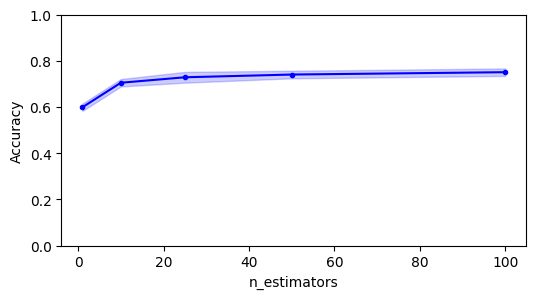

[0.59877551 0.70489796 0.72857143 0.74040816 0.75061224]


In [8]:
########## RFT #############
#------ n_estimators ------#

n_splits = 7
kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
n_estimators = [1,10,25,50,100]
accuracies_rft = np.zeros((len(n_estimators), n_splits))

for i, n in enumerate(n_estimators):
    model_rft = RandomForestClassifier(n_estimators=n)
    
    for k, idx in enumerate(kf.split(X_train,y_train)):
            (idx_learn, idx_val) = idx
            model_rft.fit(X_train[idx_learn], y_train[idx_learn])
            prediction_rft = model_rft.predict(X_train[idx_val])
            accuracies_rft[i,k] = accuracy(prediction_rft, y_train[idx_val])
        
means_rft = accuracies_rft.mean(axis=1)
stds_rft = accuracies_rft.std(axis=1)


plt.figure(figsize=(6,3))
plt.plot(n_estimators, means_rft, '.-b')
plt.fill_between(n_estimators,means_rft-stds_rft,means_rft+stds_rft,alpha=0.2,color='b')
#plt.xticks(np.arange(0,len(gamma),1),["scale","auto", 0.1, 0.2, 0.5, 0.7, 1.0, 2.0, 5.0, 10.0, 50.0])
plt.ylim(0,1)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.show()
print(means_rft)

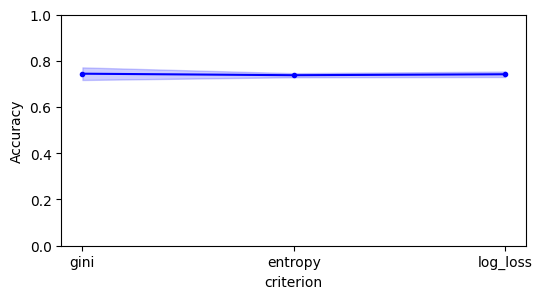

[0.74408163 0.73755102 0.74163265]


In [9]:
########## RFT #############
#------- criterion --------#

n_splits = 7
kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
criterion =["gini","entropy","log_loss"]
accuracies_rft = np.zeros((len(criterion), n_splits))

for i, c in enumerate(criterion):
    model_rft = RandomForestClassifier(criterion=c)
    
    for k, idx in enumerate(kf.split(X_train,y_train)):
            (idx_learn, idx_val) = idx
            model_rft.fit(X_train[idx_learn], y_train[idx_learn])
            prediction_rft = model_rft.predict(X_train[idx_val])
            accuracies_rft[i,k] = accuracy(prediction_rft, y_train[idx_val])
        
means_rft = accuracies_rft.mean(axis=1)
stds_rft = accuracies_rft.std(axis=1)


plt.figure(figsize=(6,3))
plt.plot(np.arange(0,len(criterion),1), means_rft, '.-b')
plt.fill_between(np.arange(0,len(criterion),1),means_rft-stds_rft,means_rft+stds_rft,alpha=0.2,color='b')
plt.xticks(np.arange(0,len(criterion),1),criterion)
plt.ylim(0,1)
plt.xlabel('criterion')
plt.ylabel('Accuracy')
plt.show()
print(means_rft)

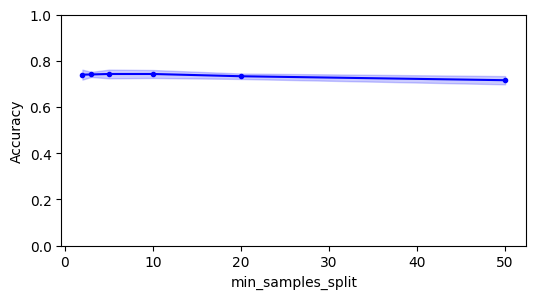

[0.74       0.74081633 0.74285714 0.74285714 0.73306122 0.71591837]


In [10]:
########## RFT #############
#---- min_samples_split ---#

n_splits = 7
kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
min = [2,3,5,10,20,50]
accuracies_rft = np.zeros((len(min), n_splits))

for i, n in enumerate(min):
    model_rft = RandomForestClassifier(min_samples_split=n)
    
    for k, idx in enumerate(kf.split(X_train,y_train)):
            (idx_learn, idx_val) = idx
            model_rft.fit(X_train[idx_learn], y_train[idx_learn])
            prediction_rft = model_rft.predict(X_train[idx_val])
            accuracies_rft[i,k] = accuracy(prediction_rft, y_train[idx_val])
        
means_rft = accuracies_rft.mean(axis=1)
stds_rft = accuracies_rft.std(axis=1)


plt.figure(figsize=(6,3))
plt.plot(min, means_rft, '.-b')
plt.fill_between(min,means_rft-stds_rft,means_rft+stds_rft,alpha=0.2,color='b')
#plt.xticks(np.arange(0,len(gamma),1),["scale","auto", 0.1, 0.2, 0.5, 0.7, 1.0, 2.0, 5.0, 10.0, 50.0])
plt.ylim(0,1)
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.show()
print(means_rft)

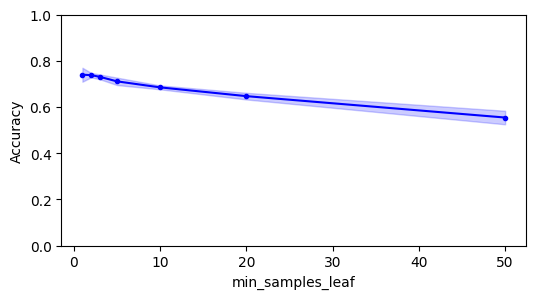

[0.73959184 0.73795918 0.73061224 0.71102041 0.68489796 0.64693878
 0.55428571]


In [11]:
########## RFT #############
#---- min_samples_leaf ----#

n_splits = 7
kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
min = [1,2,3,5,10,20,50]
accuracies_rft = np.zeros((len(min), n_splits))

for i, n in enumerate(min):
    model_rft = RandomForestClassifier(min_samples_leaf=n)
    
    for k, idx in enumerate(kf.split(X_train,y_train)):
            (idx_learn, idx_val) = idx
            model_rft.fit(X_train[idx_learn], y_train[idx_learn])
            prediction_rft = model_rft.predict(X_train[idx_val])
            accuracies_rft[i,k] = accuracy(prediction_rft, y_train[idx_val])
        
means_rft = accuracies_rft.mean(axis=1)
stds_rft = accuracies_rft.std(axis=1)


plt.figure(figsize=(6,3))
plt.plot(min, means_rft, '.-b')
plt.fill_between(min,means_rft-stds_rft,means_rft+stds_rft,alpha=0.2,color='b')
#plt.xticks(np.arange(0,len(gamma),1),["scale","auto", 0.1, 0.2, 0.5, 0.7, 1.0, 2.0, 5.0, 10.0, 50.0])
plt.ylim(0,1)
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.show()
print(means_rft)

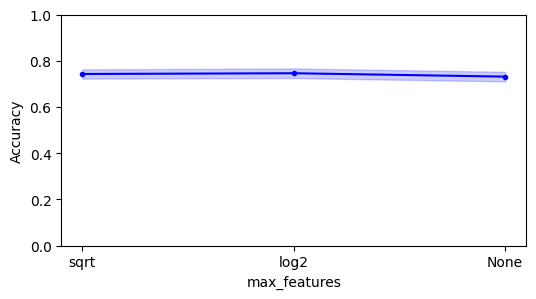

[0.74285714 0.74612245 0.73142857]


In [8]:
########## RFT #############
#---- min_samples_split ---#

n_splits = 7
kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
max_features = ["sqrt","log2", None]
accuracies_rft = np.zeros((len(max_features), n_splits))

for i, m in enumerate(max_features):
    model_rft = RandomForestClassifier(max_features=m)
    
    for k, idx in enumerate(kf.split(X_train,y_train)):
            (idx_learn, idx_val) = idx
            model_rft.fit(X_train[idx_learn], y_train[idx_learn])
            prediction_rft = model_rft.predict(X_train[idx_val])
            accuracies_rft[i,k] = accuracy(prediction_rft, y_train[idx_val])
        
means_rft = accuracies_rft.mean(axis=1)
stds_rft = accuracies_rft.std(axis=1)


plt.figure(figsize=(6,3))
plt.plot(np.arange(0,len(max_features),1), means_rft, '.-b')
plt.fill_between(np.arange(0,len(max_features),1),means_rft-stds_rft,means_rft+stds_rft,alpha=0.2,color='b')
plt.xticks(np.arange(0,len(max_features),1),["sqrt","log2","None"])
plt.ylim(0,1)
plt.xlabel('max_features')
plt.ylabel('Accuracy')
plt.show()
print(means_rft)

<font size=5 color=#009999> --- Saving the models ---</font> <br>

In [48]:
filename = 'RFT_with_proba_V2_normalized.pickle'
pickle.dump(model_rft, open(model_dir+filename, 'wb'))